In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

data = pd.read_csv("../input/train.csv")

['test.csv', 'train.csv', 'sample_submission.csv']


**Exploring data and preprocessing**

In [22]:
data.info() # all non-null integers, n = 7438, d = 12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7438 entries, 0 to 7437
Data columns (total 12 columns):
ID                                    7438 non-null int64
Elevation                             7438 non-null int64
Aspect                                7438 non-null int64
Slope                                 7438 non-null int64
Horizontal_Distance_To_Hydrology      7438 non-null int64
Vertical_Distance_To_Hydrology        7438 non-null int64
Horizontal_Distance_To_Roadways       7438 non-null int64
Hillshade_9am                         7438 non-null int64
Hillshade_Noon                        7438 non-null int64
Hillshade_3pm                         7438 non-null int64
Soil_Type                             7438 non-null int64
Horizontal_Distance_To_Fire_Points    7438 non-null int64
dtypes: int64(12)
memory usage: 697.4 KB


In [23]:
data.head() # first 5 entries of data

,ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Soil_Type,Horizontal_Distance_To_Fire_Points
0,437495769,3106,347,5,42,1,1400,210,231,160,7202,1348
1,2983472225,3132,121,1,0,0,466,221,237,152,7101,2614
2,4070272466,3255,69,13,162,16,870,233,214,110,7756,904
3,5686764697,3208,64,19,362,64,1473,234,199,90,7201,4831
4,5721364516,3224,149,15,255,59,1604,239,238,124,7202,1557


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f198aeeeda0>,
      dtype=object)

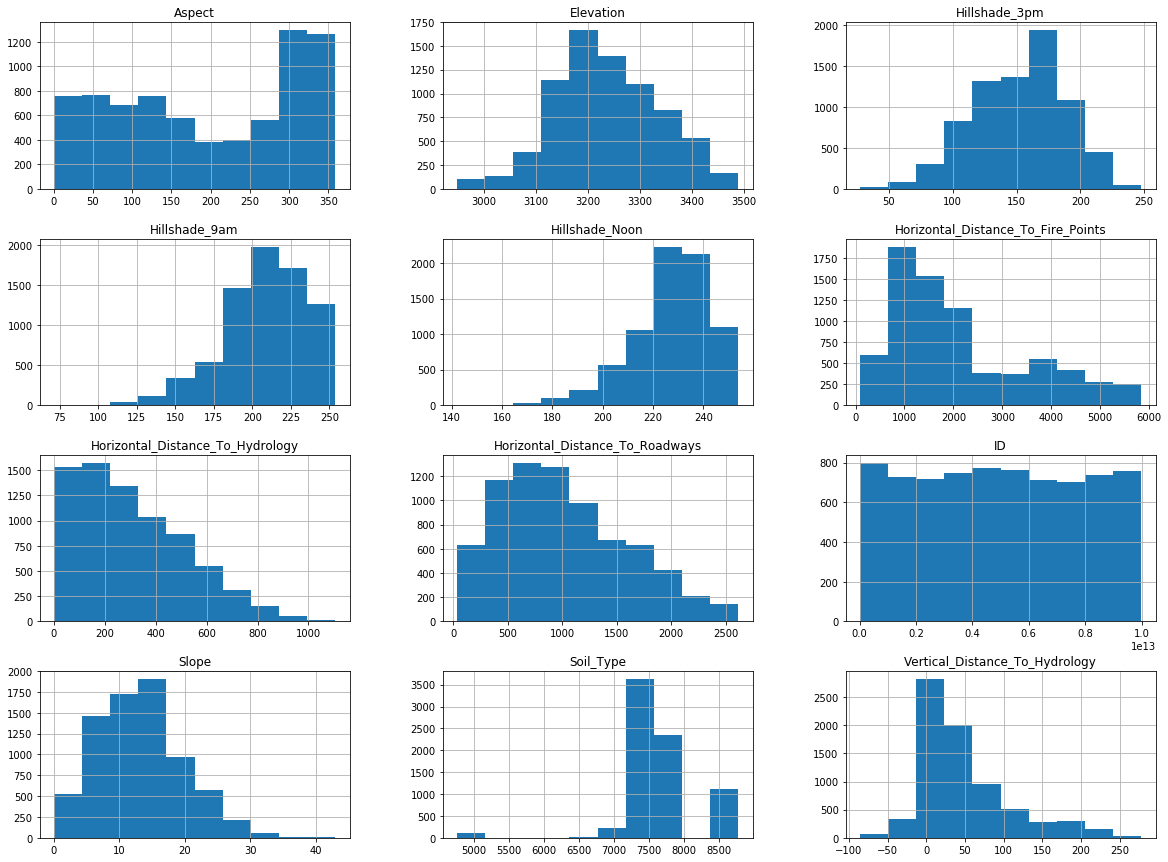

In [24]:
data.hist(bins = 10, figsize = (20,15)) # histogram

In [25]:
data.describe() # summary statistics

,ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Soil_Type,Horizontal_Distance_To_Fire_Points
count,7.438000e+03,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,4.965213e+12,3237.099758,194.653536,13.145873,307.951331,47.815407,1016.152864,208.220355,227.422291,152.502017,7566.133773,2112.133235
std,2.908520e+12,99.783831,115.218272,6.444191,214.670351,58.630660,578.100903,26.598236,15.636032,35.547152,638.996916,1389.739281
min,4.374958e+08,2947.000000,0.000000,0.000000,0.000000,-86.000000,30.000000,71.000000,142.000000,27.000000,4758.000000,85.000000
25%,2.474707e+12,3167.000000,90.000000,8.000000,134.000000,6.000000,558.000000,193.000000,220.000000,126.000000,7202.000000,1050.000000
50%,4.946868e+12,3229.000000,199.500000,13.000000,270.000000,31.000000,933.000000,210.000000,229.000000,157.000000,7202.000000,1698.500000
75%,7.486356e+12,3309.000000,309.000000,17.000000,450.000000,71.000000,1405.000000,230.000000,238.000000,178.000000,7757.000000,2994.750000
max,9.998247e+12,3489.000000,359.000000,43.000000,1106.000000,278.000000,2619.000000,254.000000,254.000000,248.000000,8776.000000,5845.000000


In [26]:
data['Soil_Type'].value_counts() # categorical?
# based on the USFS Ecological Landtype Units (ELUs) for this study area. 
# The first digit refers to the climatic zone, the second refers to the geologic. 
# The third and fourth ELU digits are unique to the mapping unit and have no special meaning to the climatic or geologic zones.

7202    2199
7201    1424
7756     864
7757     860
8771     393
7700     362
8776     333
7101     203
8703     200
8772     182
7755     179
4758     105
7701      59
6731      28
7102      26
7745      21
Name: Soil_Type, dtype: int64

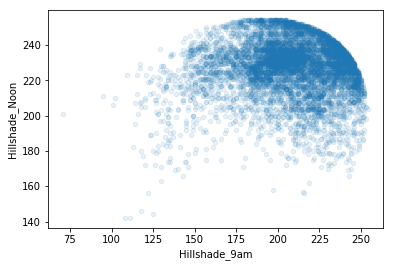

In [27]:
fire = data.copy() # copy for us to play around with
fire.plot(kind='scatter', x='Hillshade_9am', y='Hillshade_Noon', alpha=0.1) # alpha lets us visualize high-density areas

In [28]:
fire['Soil_Type'] # separates each digit of Soil_Type, which I think is categorical
fire['elu_cli'] = [int(str(a)[0]) for a in fire['Soil_Type']]
fire['elu_geo'] = [int(str(a)[1]) for a in fire['Soil_Type']]
fire['elu_3'] = [int(str(a)[2]) for a in fire['Soil_Type']]
fire['elu_4'] = [int(str(a)[3]) for a in fire['Soil_Type']]

In [29]:
# explore.plot(kind="scatter", x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology",alpha=0.5,
#               c="Horizontal_Distance_To_Fire_Points", cmap=plt.get_cmap("jet"), colorbar=True
#             )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1810198d30>,
      dtype=object)

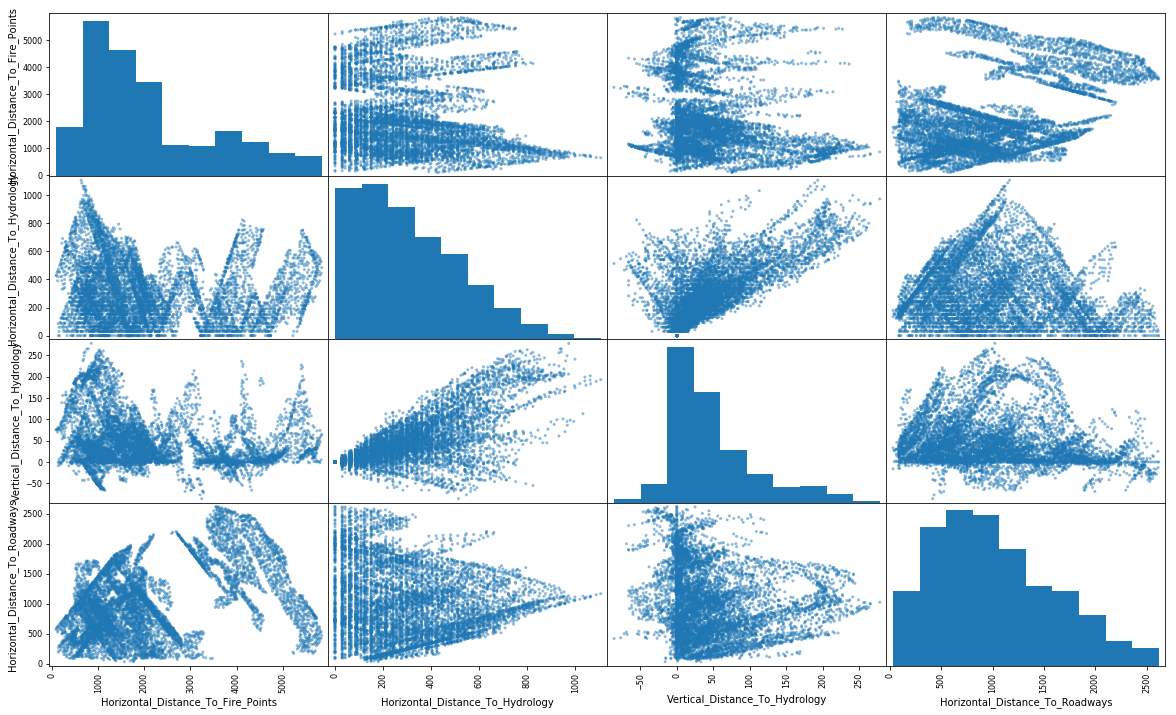

In [30]:
from pandas.plotting import scatter_matrix # correlation plots

attributes = ["Horizontal_Distance_To_Fire_Points", "Horizontal_Distance_To_Hydrology", 
              "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways"]
scatter_matrix(fire[attributes], figsize=(20,12))

# divided around Horizontal_Distance_To_Fire_Points = 3000

In [31]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7438 entries, 0 to 7437
Data columns (total 16 columns):
ID                                    7438 non-null int64
Elevation                             7438 non-null int64
Aspect                                7438 non-null int64
Slope                                 7438 non-null int64
Horizontal_Distance_To_Hydrology      7438 non-null int64
Vertical_Distance_To_Hydrology        7438 non-null int64
Horizontal_Distance_To_Roadways       7438 non-null int64
Hillshade_9am                         7438 non-null int64
Hillshade_Noon                        7438 non-null int64
Hillshade_3pm                         7438 non-null int64
Soil_Type                             7438 non-null int64
Horizontal_Distance_To_Fire_Points    7438 non-null int64
elu_cli                               7438 non-null int64
elu_geo                               7438 non-null int64
elu_3                                 7438 non-null int64
elu_4                  

In [32]:
fireX = fire.drop(['Horizontal_Distance_To_Fire_Points', 'Soil_Type', 'ID'], axis=1) # takes out Y values from dataset (X)
fireY = fire['Horizontal_Distance_To_Fire_Points'].copy()       # only the Y values

In [33]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

# for selecting relevant features
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

cat_attribs = ['elu_cli', 'elu_geo', 'elu_3', 'elu_4'] # categorical attributes
fire_num = fireX.drop(cat_attribs, axis=1) # numerical attributes
num_attribs = list(fire_num)

# pipeline for selecting and scaling numerical attributes
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler())
])

encoder = OneHotEncoder()

# pipeline for selecting and one-hot encoding categorical attributes
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('encoder', encoder),
])

In [34]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# transform the data according to pipeline
fireX = full_pipeline.fit_transform(fireX).toarray()

fireX = pd.DataFrame(fireX, columns = list(fire_num.columns) + list(range(20))) # retain names of columns
fireX.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.313926,1.322331,-1.264149,-1.238966,-0.798534,0.664024,0.066913,0.228827,0.210945,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.053345,-0.639295,-1.884905,-1.434628,-0.815591,-0.951719,0.480502,0.612582,-0.014124,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.179402,-1.090643,-0.022638,-0.679932,-0.542678,-0.252832,0.931690,-0.858478,-1.195732,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.291648,-1.134042,0.908496,0.251792,0.276062,0.790308,0.969289,-1.817865,-1.758403,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.131290,-0.396262,0.287740,-0.246680,0.190776,1.016927,1.157284,0.676541,-0.801863,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Selecting model and training data**

In [35]:
from sklearn.linear_model import LinearRegression

fire_prepared = fireX
lin_reg = LinearRegression()
lin_reg.fit(fire_prepared, fireY)

preds = pd.Series(lin_reg.predict(fire_prepared))

# linear regression without any feature engineering
# E_in = 1048.27

In [36]:
from sklearn.svm import SVR

svm_reg = SVR(kernel = 'linear')
svm_reg.fit(fire_prepared, fireY)

preds = pd.Series(svm_reg.predict(fire_prepared))

# SVM regression with linear kernel
# E_in = 1104.44

In [37]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(fire_prepared)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly, fireY)

# fourth order polynomial regression, overfits a lot
# E_in = 229.79

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [38]:
preds = pd.Series(lin_reg2.predict(X_poly))

In [39]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(fireY, preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

229.79243527377133

In [40]:
for i in range(len(preds)):
    print(preds[i], fireY[i])

1272.8846745491028 1348
2614.286708831787 2614
1015.7952628135681 904
4892.337753295898 4831
1452.9950280189514 1557
2078.829273700714 1831
1784.5206151008606 1691
5225.487662792206 5220
1727.1496758460999 1727
1544.0009512901306 1374
395.8467741012573 424
618.5598502159119 644
4294.115400314331 4294
800.7687163352966 771
1766.5302948951721 1766
4124.485409736633 4001
3608.7365641593933 3610
1298.0108485221863 1533
3581.2117114067078 3581
581.3166813850403 752
1170.9088687896729 1170
960.0563073158264 1006
2108.206596851349 2616
1070.9800534248352 1015
1877.921272277832 1878
3627.8971276283264 3628
2371.4323263168335 2408
835.4545359611511 666
951.8252186775208 849
2730.8679151535034 2731
522.9388418197632 671
2142.0723843574524 2197
1704.834804534912 2079
2218.5327954292297 2576
865.9265789985657 1110
2154.5629291534424 2213
872.7012991905212 824
1113.4491620063782 553
1139.521713733673 1384
5512.609877586365 5332
1439.8688035011292 1471
775.2219195365906 738
1974.6592736244202 1921
2

1952.218339920044 1950
471.1451859474182 661
2158.1645913124084 2018
668.4465365409851 774
3657.064116001129 3734
4511.326038837433 4599
2743.0077719688416 2769
3856.276379108429 3856
1810.0140309333801 1935
1807.836925983429 2250
2970.9775042533875 2559
2565.3269000053406 2448
2159.6339688301086 1956
2074.5269532203674 2207
1699.614622592926 1784
5368.927152633667 5435
1362.5848984718323 1176
2000.770519733429 1626
1117.8440027236938 1075
5078.306710720062 5009
1231.7136015892029 1170
944.6664128303528 778
1709.2876286506653 1954
825.1088833808899 812
3940.488880634308 2672
561.4651021957397 492
1212.030861377716 1348
1256.178922176361 1273
2398.940613269806 2256
1528.6741938591003 1410
1472.0998277664185 1365
2871.647306919098 2869
595.2856411933899 595
1316.4604477882385 1158
1038.2134900093079 1022
921.8364491462708 832
1757.2718777656555 1934
683.5808877944946 853
3967.6931672096252 3968
3747.1133942604065 3852
815.7031788825989 924
848.1474366188049 808
3608.2314348220825 3625
75

4824.606753349304 4724
1000.7267136573792 1138
1384.655170917511 1436
3133.1820669174194 3130
3618.8487315177917 3516
1621.8570790290833 1958
2072.1418080329895 2072
1086.8260569572449 1087
256.9248785972595 594
2206.428390979767 2274
1477.4693093299866 1699
1422.9895462989807 1310
1699.0839862823486 1699
3519.5208859443665 4138
1147.9710621833801 892
1671.9036979675293 1602
3114.0828189849854 3133
1762.713526725769 1587
3198.2920784950256 3198
1033.1283421516418 1012
1871.6674661636353 1889
2207.6067662239075 2208
2635.8084301948547 3078
4439.0473737716675 4439
3052.774251937866 3015
4249.065358161926 4272
815.5056533813477 806
1934.92693567276 1784
3246.3381266593933 3141
4096.452590465546 4096
4277.1208329200745 4353
916.9022259712219 860
1567.870460987091 1618
734.3867497444153 677
1670.9774422645569 1566
5696.9917249679565 5743
2826.643066883087 3114
4944.915092468262 5042
1314.7771592140198 1383
1579.0696511268616 1579
4240.526288509369 4241
1692.5391354560852 1302
1978.336527347

1699.3793210983276 1584
714.1306457519531 685
926.9053144454956 927
4104.233862400055 4091
4637.372375965118 5444
2877.7369408607483 2240
2025.988600730896 1899
571.4064378738403 664
1248.2570729255676 1288
1438.5955057144165 1507
845.9946937561035 807
798.8843898773193 902
1281.7309617996216 1209
2099.6686754226685 1931
522.8468170166016 362
3009.242619037628 3009
3948.1903805732727 3824
1619.7246007919312 1650
998.5925822257996 741
1204.6898393630981 1182
940.4637789726257 768
1887.3019795417786 1766
5053.692615509033 5072
4473.967965602875 4534
1902.4065027236938 1777
1848.9435601234436 1761
4306.181182384491 4241
1088.741274356842 1159
2271.5659852027893 2271
1212.758135318756 1213
1841.3900218009949 1825
1730.8731961250305 1964
4047.583436012268 3900
3672.846173286438 3833
1685.020833015442 1801
1123.1327748298645 1195
1057.7536034584045 808
4114.121290683746 4135
1444.0931024551392 1451
449.07203340530396 430
2775.1433987617493 2181
2526.7543263435364 2375
2737.0469603538513 2533

1224.07714509964 1578
4103.602482795715 4126
534.8425240516663 780
4043.7140407562256 4001
1638.8416299819946 1639
1590.9228620529175 1591
3381.189579486847 2640
1554.8827004432678 1348
4570.841476917267 4564
1885.638623714447 2060
1562.7975525856018 1698
5389.976762771606 5320
1790.370913028717 1774
3002.7605953216553 3108
656.0303978919983 731
1623.9113583564758 1624
1511.4478077888489 1533
3247.741189956665 3375
5048.777015209198 5101
1635.5170845985413 1624
1631.8113503456116 1632
4207.6063323020935 4161
4251.067125320435 4147
1159.7695379257202 1476
5840.219565868378 5710
1677.5243000984192 1610
1248.1487936973572 1248
905.6530256271362 900
4737.371001243591 4896
534.1007838249207 534
1333.9627084732056 1036
2014.5896978378296 2030
3841.099308013916 4140
2021.9709920883179 2022
1128.062740802765 1129
1284.2993531227112 1966
2461.9934096336365 2462
3095.753206729889 2583
1259.786955833435 1260
1669.0495190620422 1426
1334.503468990326 1230
1472.3441400527954 1343
2063.171214580536 

2147.6179127693176 2046
1117.7613549232483 1426
1733.1921849250793 1591
5485.41081237793 5275
2276.455888271332 2315
4248.41079044342 4055
3238.357105731964 2254
1102.3745350837708 1031
1425.044497013092 1571
1742.7480130195618 1906
4580.698094367981 4712
1654.8988494873047 1655
3104.1564712524414 3062
1438.952082157135 1693
2166.5683331489563 1934
4478.014123916626 4478
958.044928073883 1012
2225.0345373153687 2148
684.146312713623 810
1733.5329308509827 1732
5618.917110443115 5653
349.4407444000244 433
2485.743463039398 2666
1100.9078164100647 1054
883.4334526062012 767
2046.6891503334045 2603
4945.580852508545 5103
1857.3391733169556 1846
906.2032322883606 1369
2427.7958936691284 2502
993.9411072731018 994
3975.457055091858 4336
2001.3607511520386 1699
773.6453137397766 918
4759.689880371094 4444
2240.892897605896 2440
1552.7679781913757 1489
424.2092185020447 300
1849.3334412574768 1828
1089.8001747131348 892
1648.8521356582642 1557
2069.1448636054993 2069
2320.7426533699036 2010
1

1815.1139359474182 1597
6030.964567661285 5750
2217.1923265457153 2493
508.59912967681885 451
125.62331104278564 446
3868.1358246803284 3846
1809.153934955597 1708
2147.921305179596 1892
1638.4400882720947 1879
516.1811852455139 516
3669.2134313583374 3672
2294.952112674713 2295
4836.037619590759 4861
3577.623321056366 3690
808.265697479248 990
1578.9617829322815 1571
1143.1723732948303 1061
868.9032807350159 830
1280.044930934906 1170
1611.92289686203 1612
4933.573887348175 4881
921.9443688392639 916
1668.1567163467407 1914
2012.9328446388245 1939
4507.257740020752 4542
3717.732946395874 3902
3906.222551345825 3886
1290.8070244789124 1812
1146.162124633789 1500
4451.160485267639 4394
1617.0958142280579 1549
2322.64505815506 1961
773.6088352203369 819
3783.951038837433 3863
1063.0457253456116 892
5209.815845489502 5104
1215.632709980011 1253
1671.3762736320496 2083
1540.5378017425537 1556
1916.91961145401 1727
921.5853667259216 900
1163.4295568466187 1126
497.3346848487854 866
1410.940

1928.8204731941223 1839
3363.1157183647156 3570
2480.063238620758 2135
2230.2642045021057 1998
1263.2333779335022 993
752.5469617843628 942
1786.917055606842 2075
836.0189290046692 800
2446.0769448280334 2045
1782.6060452461243 1772
1094.0804886817932 1165
1883.8282361030579 1907
1899.9893879890442 1917
2269.743046283722 2210
998.5526313781738 1041
1096.146258354187 1140
590.9478669166565 591
797.2630705833435 618
450.7599892616272 825
1455.373152256012 1387
1879.2758865356445 1919
2528.7610783576965 2529
2010.499180316925 1871
872.9659218788147 850
732.8991212844849 547
3722.965901374817 3783
1800.9321675300598 1318
543.017825126648 421
969.3583555221558 882
5351.949474811554 5402
1467.6074986457825 1374
640.1925091743469 858
715.4286336898804 376
1645.3849987983704 1503
316.69231700897217 331
1638.249499797821 1650
509.6183180809021 541
3301.7874574661255 3162
1254.084146976471 1087
1431.4179043769836 1620
995.1629076004028 999
1381.0309834480286 1200
1017.3836150169373 866
548.41402

1078.501492023468 883
4770.558305740356 4716
2287.815737247467 2493
5527.630805015564 5188
1806.1994996070862 874
1324.5922441482544 1387
1068.8799905776978 895
4713.786581516266 5531
727.8124380111694 708
966.3730645179749 741
1523.8357281684875 1292
254.64988613128662 488
1943.2438836097717 1974
1190.5313630104065 1233
2265.9340138435364 2244
5125.778022766113 4965
3544.2017693519592 3544
1600.2526717185974 745
706.8204007148743 700
3562.665909767151 4005
1608.4297451972961 1937
3384.035964488983 3384
660.8363308906555 524
1337.0782384872437 1317
1104.3847212791443 1422
4061.464089870453 4052
4693.061947345734 4772
3846.5791897773743 3999
1014.7170782089233 726
2291.5619807243347 2601
943.329451084137 949
1042.2387619018555 1115
1559.1642079353333 1100
1832.2626304626465 1632
1094.439646244049 1299
3254.856098651886 3255
1022.0849604606628 1022
1222.8843998908997 1243
3265.4995403289795 3205
1121.3082146644592 1221
1557.1196999549866 1293
3988.0253477096558 3931
1150.7080597877502 10

894.2632718086243 816
1315.3859720230103 900
875.1034054756165 553
714.2971186637878 849
3891.3070645332336 4020
2013.7703919410706 2014
5183.947824001312 5021
658.8483047485352 914
1869.465572834015 2123
1657.3104300498962 1657
1720.8232865333557 2442
4634.546932697296 5557
768.4402270317078 850
2216.1221833229065 2287
1223.4162888526917 1181
1159.2288136482239 1298
1125.9176659584045 721
405.68680238723755 534
3453.346869468689 3523
4378.450238704681 3780
943.2697920799255 607
4665.389581680298 4743
944.3853344917297 1019
1167.9141092300415 1211
679.1041197776794 679
2897.8853402137756 2748
2407.9481539726257 2297
687.6805872917175 663
1930.9331016540527 1931
2696.012556552887 2242
1328.53315782547 1209
1093.938425540924 870
641.6399855613708 618
1898.5317006111145 2350
2132.2364830970764 1994
1570.360770225525 1689
1784.9334988594055 1862
2286.6238555908203 2287
1576.2957105636597 1616
1142.7638893127441 1052
1409.4429745674133 2255
1353.1334810256958 1383
4313.33092212677 4529
1230

**Predictions**

In [ ]:
test = pd.read_csv("../input/test.csv")
test['elu_cli'] = [int(str(a)[0]) for a in test['Soil_Type']]
test['elu_geo'] = [int(str(a)[1]) for a in test['Soil_Type']]
test['elu_3'] = [int(str(a)[2]) for a in test['Soil_Type']]
test['elu_4'] = [int(str(a)[3]) for a in test['Soil_Type']]

test

# fireX = fire.drop(['Soil_Type', 'ID'], axis=1) # takes out Y values from dataset

# fireX = full_pipeline.fit_transform(fireX).toarray()

# fireX = pd.DataFrame(fireX, columns = list(fire_num.columns) + list(range(20))) # retain names of columns
# fireX.head()

# X_poly = poly_reg.fit_transform(fireX)

# preds = pd.Series(lin_reg2.predict(X_poly))

In [ ]:
for i in range(len(preds)):
    print(i, '{0:.4g}'.format(preds[i]))

In [ ]:
fireX

**Cross validation**